# State Space Models: From Time Series to Kalman Filtering

This notebook provides hands-on implementations of the concepts covered in the lecture slides.

### Contents:
1. Converting AR models to state space form
2. Discretizing continuous-time systems
3. Implementing the Kalman filter
4. Applications: tracking and signal processing
5. Visualizations for slides

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import expm
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

np.random.seed(42)

## 1. From Time Series to State Space: AR(2) Example

We'll convert an AR(2) model to state space form and show they're equivalent.

Auto-regressive Model (for time-series state-based models): 
$$y_t = \phi _1 * y_{t-1} + \phi _2 * y_{t-2} + ... + \phi _p * y_{t-p} + \epsilon _t$$

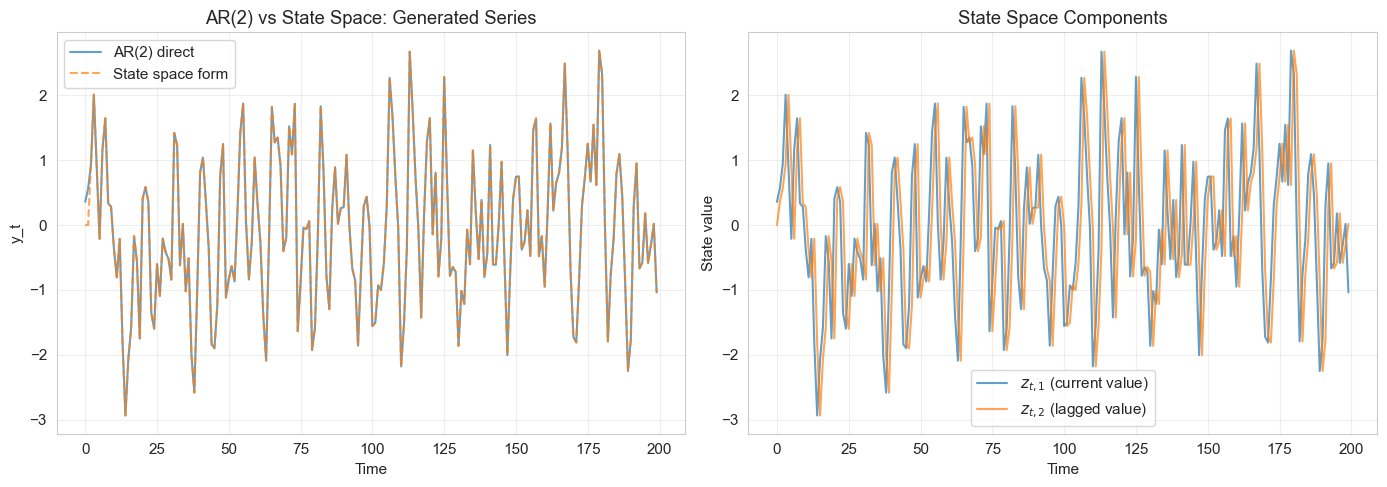

AR(2) State Transition Matrix F:
[[ 0.7 -0.3]
 [ 1.   0. ]]

Observation Matrix H:
[[1. 0.]]


In [2]:
# AR(2) parameters: y_t = phi_1 * y_{t-1} + phi_2 * y_{t-2} + epsilon_t
# Predefined noise factors
phi_1 = 0.7
phi_2 = -0.3
sigma_epsilon = 1.0

# Generate AR(2) data directly
T = 200
epsilon = sigma_epsilon * np.random.randn(T) # noise
y_ar = np.zeros(T)
y_ar[0] = np.random.randn()
y_ar[1] = np.random.randn()

for t in range(2, T):
    y_ar[t] = phi_1 * y_ar[t-1] + phi_2 * y_ar[t-2] + epsilon[t]

# Convert to state space form
# State: z_t = [y_t, y_{t-1}]^T
F = np.array([[phi_1, phi_2],
              [1.0,   0.0]])
H = np.array([[1.0, 0.0]])  # Observe only first component
Q = np.array([[sigma_epsilon**2, 0.0],
              [0.0,              0.0]])
R = np.array([[0.0]])  # No observation noise for this example

# Simulate using state space form
n_z = 2
n_y = 1
z = np.zeros((T, n_z)) # predicted states
y_ss = np.zeros((T, n_y)) # lookup observations

z[0] = [y_ar[0], 0]
z[1] = [y_ar[1], y_ar[0]]

for t in range(2, T):
    # Transition
    q_t = np.array([epsilon[t], 0])
    #q_t = np.random.multivariate_normal([0, 0], Q)
    z[t] = F @ z[t-1] + q_t # matmul + transition noise
    # Observation
    y_ss[t] = H @ z[t]  # H extracts the observable from the hidden state (projects state to observation space)

# Plot comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(y_ar, label='AR(2) direct', alpha=0.7)
plt.plot(y_ss, label='State space form', alpha=0.7, linestyle='--')
plt.title('AR(2) vs State Space: Generated Series')
plt.xlabel('Time')
plt.ylabel('y_t')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(z[:, 0], label='$z_{t,1}$ (current value)', alpha=0.7)
plt.plot(z[:, 1], label='$z_{t,2}$ (lagged value)', alpha=0.7)
plt.title('State Space Components')
plt.xlabel('Time')
plt.ylabel('State value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('/home/claude/ar2_to_ssm.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"AR(2) State Transition Matrix F:\n{F}")
print(f"\nObservation Matrix H:\n{H}")

**Figure for slides:** `ar2_to_ssm.png` - Shows equivalence between AR(2) and SSM representations

## 2. Discretization: Spring-Mass-Damper System

Convert continuous-time dynamics to discrete-time using both Euler and exact methods.

Continuous-time system:
A_c =
[[ 0.   1. ]
 [-2.  -0.5]]

B_c =
[[0.]
 [1.]]

=== dt = 0.01 ===
F_euler =
[[ 1.     0.01 ]
 [-0.02   0.995]]

F_exact =
[[ 0.99990017  0.00997471]
 [-0.01994942  0.99491281]]

Difference norm: 0.000144

=== dt = 0.1 ===
F_euler =
[[ 1.    0.1 ]
 [-0.2   0.95]]

F_exact =
[[ 0.99018093  0.09721635]
 [-0.1944327   0.94157275]]

Difference norm: 0.014359

=== dt = 0.5 ===
F_euler =
[[ 1.    0.5 ]
 [-1.    0.75]]

F_exact =
[[ 0.77887612  0.40647966]
 [-0.81295932  0.57563629]]

Difference norm: 0.350755


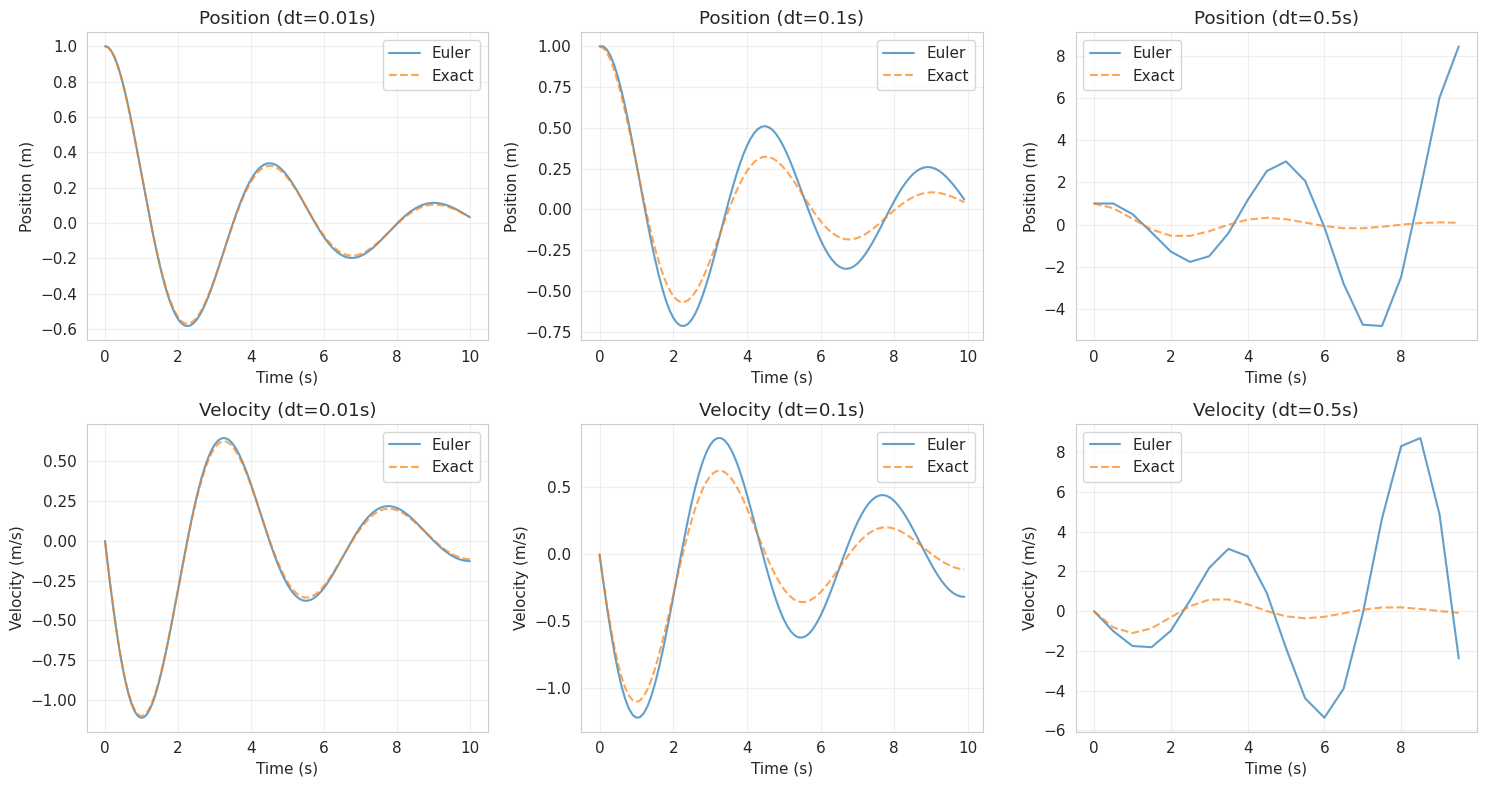

In [3]:
# Spring-mass-damper parameters
m = 1.0   # mass (kg)
c = 0.5   # damping coefficient
k = 2.0   # spring constant

# Continuous-time state space matrices
A_c = np.array([[0,      1],
                [-k/m, -c/m]])
B_c = np.array([[0],
                [1/m]])
C_c = np.array([[1, 0]])  # Observe position only
D_c = np.array([[0]])

print("Continuous-time system:")
print(f"A_c =\n{A_c}")
print(f"\nB_c =\n{B_c}")

# Discretization with different sampling periods
dt_values = [0.01, 0.1, 0.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, dt in enumerate(dt_values):
    # Method 1: Euler discretization
    F_euler = np.eye(2) + dt * A_c
    B_euler = dt * B_c

    # Method 2: Exact discretization (matrix exponential)
    sys_c = signal.StateSpace(A_c, B_c, C_c, D_c)
    sys_d = sys_c.to_discrete(dt, method='zoh')  # Zero-order hold
    F_exact = sys_d.A
    B_exact = sys_d.B

    # Simulate response to initial condition [1, 0] (displaced, no velocity)
    T_sim = 10  # seconds
    n_steps = int(T_sim / dt)
    t = np.arange(n_steps) * dt

    z_euler = np.zeros((n_steps, 2))
    z_exact = np.zeros((n_steps, 2))
    z_euler[0] = [1.0, 0.0]
    z_exact[0] = [1.0, 0.0]

    for i in range(1, n_steps):
        z_euler[i] = F_euler @ z_euler[i-1]
        z_exact[i] = F_exact @ z_exact[i-1]

    # Plot position
    axes[0, idx].plot(t, z_euler[:, 0], label='Euler', alpha=0.7)
    axes[0, idx].plot(t, z_exact[:, 0], label='Exact', alpha=0.7, linestyle='--')
    axes[0, idx].set_title(f'Position (dt={dt}s)')
    axes[0, idx].set_xlabel('Time (s)')
    axes[0, idx].set_ylabel('Position (m)')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Plot velocity
    axes[1, idx].plot(t, z_euler[:, 1], label='Euler', alpha=0.7)
    axes[1, idx].plot(t, z_exact[:, 1], label='Exact', alpha=0.7, linestyle='--')
    axes[1, idx].set_title(f'Velocity (dt={dt}s)')
    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_ylabel('Velocity (m/s)')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

    print(f"\n=== dt = {dt} ===")
    print(f"F_euler =\n{F_euler}")
    print(f"\nF_exact =\n{F_exact}")
    print(f"\nDifference norm: {np.linalg.norm(F_euler - F_exact):.6f}")

plt.tight_layout()
#plt.savefig('/home/claude/discretization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

**Figure for slides:** `discretization_comparison.png` - Shows Euler vs exact discretization for different sampling rates

## 3. Kalman Filter Implementation

Implement the Kalman filter from scratch

In [3]:
class KalmanFilter:
    """Kalman Filter implementation following Murphy's notation"""

    def __init__(self, F, H, Q, R, B=None, b=None, D=None, d=None):
        """
        Initialize Kalman Filter

        Parameters:
        -----------
        F : ndarray (n_z, n_z)
            State transition matrix (The Markov Model)
        H : ndarray (n_y, n_z)
            Observation matrix (representing y)
        Q : ndarray (n_z, n_z)
            Process noise covariance (noise with multiple factors)
        R : ndarray (n_y, n_y)
            Measurement noise covariance
        B : ndarray (n_z, n_u), optional
            Control input matrix
        b : ndarray (n_z,), optional
            State bias
        D : ndarray (n_y, n_u), optional
            Control observation matrix
        d : ndarray (n_y,), optional
            Observation bias
        """
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
        self.B = B if B is not None else np.zeros((F.shape[0], 1))
        self.b = b if b is not None else np.zeros(F.shape[0])
        self.D = D if D is not None else np.zeros((H.shape[0], 1))
        self.d = d if d is not None else np.zeros(H.shape[0])

        self.n_z = F.shape[0]
        self.n_y = H.shape[0]

    def predict(self, mu_prev, Sigma_prev, u=None): # Takes previous mean and covariance
        """
        Prediction step (time update)
        
        Takes the previous state (mu_prev, Sigma_prev) and predicts the current state
        
        Parameters:
        -----------
        mu_prev : ndarray (n_z,)
            Previous state mean
        Sigma_prev : ndarray (n_z, n_z)
            Previous state covariance
        u : ndarray (n_u,), optional
            Control input
        
        Returns:
        --------
        mu_pred : ndarray (n_z,)
            Predicted state mean (current time step)
        Sigma_pred : ndarray (n_z, n_z)
            Predicted state covariance (current time step)
        """
        if u is None:
            u = np.zeros(self.B.shape[1])

        # Equation 8.23 from Murphy
        mu_pred = self.F @ mu_prev + self.B @ u + self.b

        # Equation 8.24 from Murphy
        Sigma_pred = self.F @ Sigma_prev @ self.F.T + self.Q

        return mu_pred, Sigma_pred

    def update(self, mu_pred, Sigma_pred, y, u=None): # update knowledge of predicted state
        """
        Update step (measurement update)

        Returns: mu_upd, Sigma_upd, K (Kalman gain), innovation
        """
        if u is None:
            u = np.zeros(self.D.shape[1])

        # Predicted observation (Equation 8.26)
        y_hat = self.H @ mu_pred + self.D @ u + self.d

        # Innovation (residual)
        innovation = y - y_hat

        # Innovation covariance (Equation 8.27)
        S = self.H @ Sigma_pred @ self.H.T + self.R

        # Kalman gain (Equation 8.28)
        K = Sigma_pred @ self.H.T @ np.linalg.inv(S)

        # Updated state mean (Equation 8.29)
        mu_upd = mu_pred + K @ innovation

        # Updated state covariance (Equation 8.30)
        Sigma_upd = Sigma_pred - K @ self.H @ Sigma_pred

        return mu_upd, Sigma_upd, K, innovation

    def filter(self, y_seq, u_seq=None, mu_0=None, Sigma_0=None):
        """
        Run Kalman filter on sequence of observations

        Parameters:
        -----------
        y_seq : ndarray (T, n_y)
            Sequence of observations
        u_seq : ndarray (T, n_u), optional
            Sequence of control inputs
        mu_0 : ndarray (n_z,), optional
            Initial state mean
        Sigma_0 : ndarray (n_z, n_z), optional
            Initial state covariance

        Returns:
        --------
        mu_filtered : ndarray (T, n_z)
            Filtered state means
        Sigma_filtered : ndarray (T, n_z, n_z)
            Filtered state covariances
        mu_predicted : ndarray (T, n_z)
            Predicted state means
        Sigma_predicted : ndarray (T, n_z, n_z)
            Predicted state covariances
        """
        T = len(y_seq)

        if mu_0 is None:
            mu_0 = np.zeros(self.n_z)
        if Sigma_0 is None:
            Sigma_0 = np.eye(self.n_z)
        if u_seq is None:
            u_seq = [None] * T

        # Storage
        mu_filtered = np.zeros((T, self.n_z))
        Sigma_filtered = np.zeros((T, self.n_z, self.n_z))
        mu_predicted = np.zeros((T, self.n_z))
        Sigma_predicted = np.zeros((T, self.n_z, self.n_z))

        # Initial state
        mu_prev = mu_0
        Sigma_prev = Sigma_0

        for t in range(T):
            # Predict
            mu_pred, Sigma_pred = self.predict(mu_prev, Sigma_prev, u_seq[t])
            mu_predicted[t] = mu_pred
            Sigma_predicted[t] = Sigma_pred

            # Update
            mu_upd, Sigma_upd, K, innov = self.update(mu_pred, Sigma_pred, y_seq[t], u_seq[t])
            mu_filtered[t] = mu_upd
            Sigma_filtered[t] = Sigma_upd

            # Store for next iteration
            mu_prev = mu_upd
            Sigma_prev = Sigma_upd

        return mu_filtered, Sigma_filtered, mu_predicted, Sigma_predicted

print("Kalman Filter class implemented!")

Kalman Filter class implemented!


## The Kalman Filter: Role and Steps

The **Kalman filter** is an optimal recursive algorithm for estimating the hidden state of a linear dynamical system from noisy observations. It maintains a Gaussian belief about the state at each time step, represented by a mean $\boldsymbol{\mu}_t$ and covariance $\boldsymbol{\Sigma}_t$.

---

### **Role**

The Kalman filter solves two key problems:
1. **Filtering**: Estimate the current state given all past observations
2. **Handling uncertainty**: Optimally fuse information from:
    - **Process model** (how the system evolves)
    - **Measurements** (noisy observations of the state)

It's optimal for linear-Gaussian systems, minimizing the mean squared error.

---

### **Two-Step Recursive Process**

At each time step $t$, the Kalman filter performs:

#### **1. Predict (Time Update)**
Project the state forward using the system dynamics:

$$
\begin{aligned}
\boldsymbol{\mu}_t^{\text{pred}} &= \mathbf{F}_t \boldsymbol{\mu}_{t-1} + \mathbf{B}_t \mathbf{u}_t + \mathbf{b}_t \\
\boldsymbol{\Sigma}_t^{\text{pred}} &= \mathbf{F}_t \boldsymbol{\Sigma}_{t-1} \mathbf{F}_t^\top + \mathbf{Q}_t
\end{aligned}
$$

- **Uncertainty increases** due to process noise $\mathbf{Q}_t$
- Prediction relies only on the model (no measurement yet)

#### **2. Update (Measurement Update)**
Correct the prediction using the new observation $\mathbf{y}_t$:

$$
\begin{aligned}
\text{Innovation: } \quad & \boldsymbol{\nu}_t = \mathbf{y}_t - \mathbf{H}_t \boldsymbol{\mu}_t^{\text{pred}} \\
\text{Innovation covariance: } \quad & \mathbf{S}_t = \mathbf{H}_t \boldsymbol{\Sigma}_t^{\text{pred}} \mathbf{H}_t^\top + \mathbf{R}_t \\
\text{Kalman gain: } \quad & \mathbf{K}_t = \boldsymbol{\Sigma}_t^{\text{pred}} \mathbf{H}_t^\top \mathbf{S}_t^{-1} \\
\text{Updated mean: } \quad & \boldsymbol{\mu}_t = \boldsymbol{\mu}_t^{\text{pred}} + \mathbf{K}_t \boldsymbol{\nu}_t \\
\text{Updated covariance: } \quad & \boldsymbol{\Sigma}_t = \boldsymbol{\Sigma}_t^{\text{pred}} - \mathbf{K}_t \mathbf{H}_t \boldsymbol{\Sigma}_t^{\text{pred}}
\end{aligned}
$$

- **Uncertainty decreases** by incorporating measurement information
- **Kalman gain** $\mathbf{K}_t$ weighs trust between prediction and measurement

---

### **Key Intuition**

- **High measurement noise** ($\mathbf{R}_t$ large) → Trust the model more (small $\mathbf{K}_t$)
- **High process noise** ($\mathbf{Q}_t$ large) → Trust measurements more (large $\mathbf{K}_t$)

The filter automatically balances these sources of uncertainty to produce optimal estimates.

## 4. Example: 1D Tracking Problem

Track a 1D position with noisy measurements. This generates the predict-update visualization.

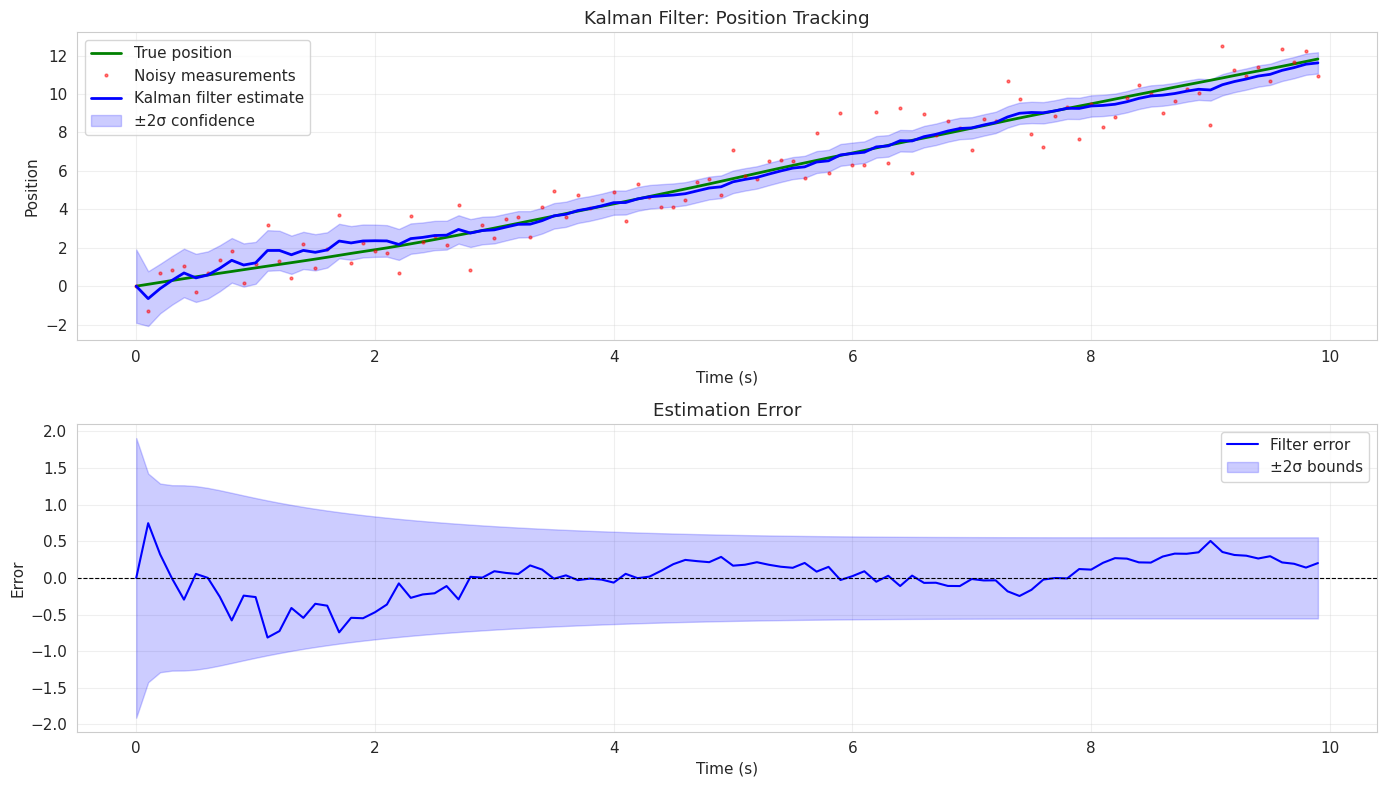

Root Mean Square Error: 0.2713


In [ ]:
# 1D constant velocity model
# State: z = [position, velocity]^T
dt = 0.1  # time step (delta t)
F_track = np.array([[1, dt],
                    [0, 1]])
H_track = np.array([[1, 0]])  # Observe position only

# Process noise: small acceleration uncertainty
q = 0.1  # process noise strength
Q_track = q * np.array([[dt**4/4, dt**3/2],
                        [dt**3/2, dt**2]])

# Measurement noise
r = 1.0  # measurement noise
R_track = np.array([[r**2]])

# Generate true trajectory
T_track = 100
z_true = np.zeros((T_track, 2))
y_obs = np.zeros((T_track, 1))

z_true[0] = [0, 1]  # Start at position 0, velocity 1

for t in range(1, T_track):
    # True dynamics with process noise
    process_noise = np.random.multivariate_normal([0, 0], Q_track)
    z_true[t] = F_track @ z_true[t-1] + process_noise

    # Noisy observation
    measurement_noise = np.random.randn() * r
    y_obs[t] = H_track @ z_true[t] + measurement_noise

# Run Kalman filter
kf = KalmanFilter(F_track, H_track, Q_track, R_track)
mu_filt, Sigma_filt, mu_pred, Sigma_pred = kf.filter(
    y_obs,
    mu_0=np.array([0, 0]),
    Sigma_0=np.eye(2) * 10
)

# Extract position estimates
pos_true = z_true[:, 0]
pos_filt = mu_filt[:, 0]
pos_pred = mu_pred[:, 0]
std_filt = np.sqrt(Sigma_filt[:, 0, 0])
std_pred = np.sqrt(Sigma_pred[:, 0, 0])

# Plot results
t_axis = np.arange(T_track) * dt

plt.figure(figsize=(14, 8))

# Position tracking
plt.subplot(2, 1, 1)
plt.plot(t_axis, pos_true, 'g-', label='True position', linewidth=2)
plt.plot(t_axis, y_obs, 'r.', label='Noisy measurements', markersize=4, alpha=0.5)
plt.plot(t_axis, pos_filt, 'b-', label='Kalman filter estimate', linewidth=2)
plt.fill_between(t_axis,
                 pos_filt - 2*std_filt,
                 pos_filt + 2*std_filt,
                 alpha=0.2, color='blue', label='±2σ confidence')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('Kalman Filter: Position Tracking')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Estimation error
plt.subplot(2, 1, 2)
error = pos_true - pos_filt
plt.plot(t_axis, error, 'b-', label='Filter error', linewidth=1.5)
plt.fill_between(t_axis, -2*std_filt, 2*std_filt, alpha=0.2, color='blue', label='±2σ bounds')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.title('Estimation Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('kalman_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute RMSE
rmse = np.sqrt(np.mean((pos_true - pos_filt)**2))
print(f"Root Mean Square Error: {rmse:.4f}")

**Figure for slides:** `kalman_tracking.png` - Demonstrates Kalman filter performance on tracking problem

## 5. Visualization: Predict-Update in 1D

Create the conceptual figure showing prediction (wider) vs update (narrower) Gaussians.

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3555977854.py:32: SyntaxWarning: invalid escape sequence '\m'
  'k--', linewidth=2, label=f'Previous: $\mathcal{{N}}$({mu_prev:.1f}, {sigma_prev**2:.2f})', alpha=0.5)
/tmp/ipython-input-3555977854.py:36: SyntaxWarning: invalid escape sequence '\m'
  'b-', linewidth=2.5, label=f'Prediction: $\mathcal{{N}}$({mu_pred:.1f}, {sigma_pred**2:.2f})')
/tmp/ipython-input-3555977854.py:41: SyntaxWarning: invalid escape sequence '\m'
  'r-', linewidth=2, label=f'Measurement: $\mathcal{{N}}$({y_meas:.1f}, {R_demo:.2f})', alpha=0.7)
/tmp/ipython-input-3555977854.py:46: SyntaxWarni

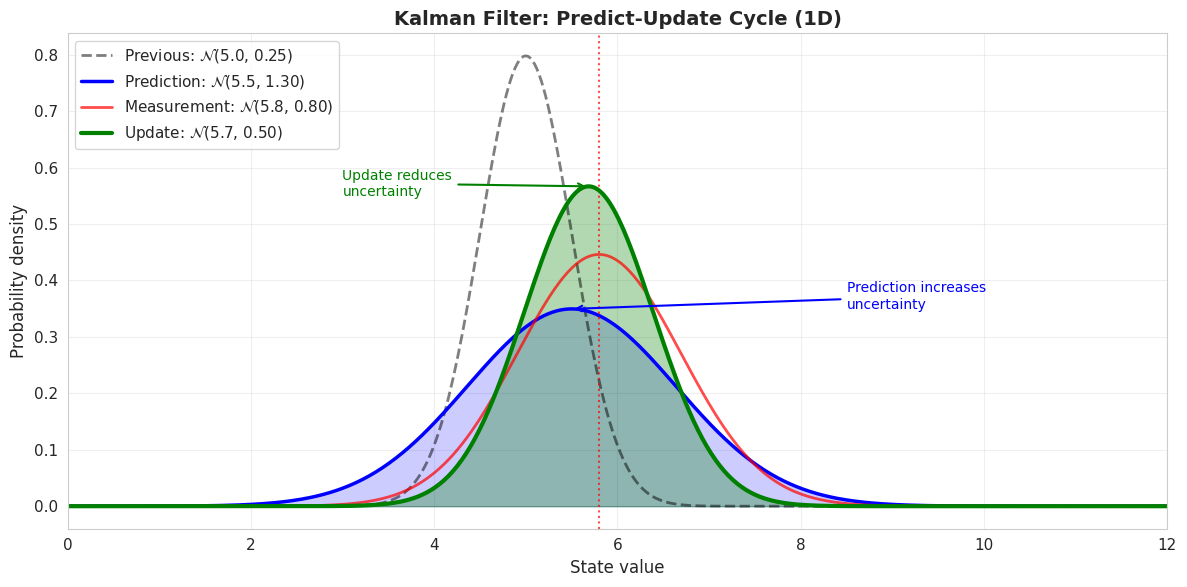

Kalman Gain K = 0.620
Innovation = 0.300
Uncertainty reduction: 1.141 → 0.704


In [6]:
from scipy.stats import norm

# Single time step demonstration
# Previous state
mu_prev = 5.0
sigma_prev = 0.5

# Prediction step (increases uncertainty)
F_demo = 1.1  # slight drift
Q_demo = 1.0  # process noise
mu_pred = F_demo * mu_prev
sigma_pred = np.sqrt((F_demo * sigma_prev)**2 + Q_demo)

# Measurement
y_meas = 5.8
R_demo = 0.8
sigma_meas = np.sqrt(R_demo)

# Update step (Kalman gain computation)
H_demo = 1.0
K_demo = (sigma_pred**2) / (sigma_pred**2 + R_demo)
mu_upd = mu_pred + K_demo * (y_meas - mu_pred)
sigma_upd = np.sqrt((1 - K_demo) * sigma_pred**2)

# Plot
x_range = np.linspace(0, 12, 500)

plt.figure(figsize=(12, 6))

# Previous state
plt.plot(x_range, norm.pdf(x_range, mu_prev, sigma_prev),
         'k--', linewidth=2, label=f'Previous: $\mathcal{{N}}$({mu_prev:.1f}, {sigma_prev**2:.2f})', alpha=0.5)

# Prediction
plt.plot(x_range, norm.pdf(x_range, mu_pred, sigma_pred),
         'b-', linewidth=2.5, label=f'Prediction: $\mathcal{{N}}$({mu_pred:.1f}, {sigma_pred**2:.2f})')
plt.fill_between(x_range, 0, norm.pdf(x_range, mu_pred, sigma_pred), alpha=0.2, color='blue')

# Measurement likelihood
plt.plot(x_range, norm.pdf(x_range, y_meas, sigma_meas),
         'r-', linewidth=2, label=f'Measurement: $\mathcal{{N}}$({y_meas:.1f}, {R_demo:.2f})', alpha=0.7)
plt.axvline(y_meas, color='r', linestyle=':', linewidth=1.5, alpha=0.7)

# Update
plt.plot(x_range, norm.pdf(x_range, mu_upd, sigma_upd),
         'g-', linewidth=3, label=f'Update: $\mathcal{{N}}$({mu_upd:.1f}, {sigma_upd**2:.2f})')
plt.fill_between(x_range, 0, norm.pdf(x_range, mu_upd, sigma_upd), alpha=0.3, color='green')

plt.xlabel('State value', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.title('Kalman Filter: Predict-Update Cycle (1D)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 12)

# Add annotations
plt.annotate('Prediction increases\nuncertainty',
            xy=(mu_pred, norm.pdf(mu_pred, mu_pred, sigma_pred)),
            xytext=(8.5, 0.35),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
            fontsize=10, color='blue')

plt.annotate('Update reduces\nuncertainty',
            xy=(mu_upd, norm.pdf(mu_upd, mu_upd, sigma_upd)),
            xytext=(3, 0.55),
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
            fontsize=10, color='green')

plt.tight_layout()
#plt.savefig('/home/claude/predict_update_visual.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Kalman Gain K = {K_demo:.3f}")
print(f"Innovation = {y_meas - mu_pred:.3f}")
print(f"Uncertainty reduction: {sigma_pred:.3f} → {sigma_upd:.3f}")

**Figure for slides:** `predict_update_visual.png` - Conceptual visualization of predict-update cycle

## 6. Extended Example: 2D Tracking (Aircraft)

Track an aircraft in 2D with position measurements but unknown velocity.

This is a **constant-velocity (CV)** tracking model in 2D. The object is assumed to move with *approximately* constant velocity, but it may experience **random accelerations** (maneuvers, small perturbations) that we do **not** explicitly model as part of the state. Those unmodeled accelerations are captured by the **process noise covariance** matrix $Q_t$.

---

### 1) State definition (what we track)

We track position and velocity in 2D:

$$
\mathbf{z}_t =
\begin{bmatrix}
x_t \\
\dot{x}_t \\
y_t \\
\dot{y}_t
\end{bmatrix},
$$

where $x_t, y_t$ are positions and $\dot{x}_t, \dot{y}_t$ are velocities.

---

### 2) Why the transition matrix $F_t$ has that form

The CV assumption corresponds to standard kinematics over a time step $\Delta t$:

- Position advances by integrating velocity:
  $$
  x_{t+1} = x_t + \Delta t\,\dot{x}_t,
  \qquad
  y_{t+1} = y_t + \Delta t\,\dot{y}_t.
  $$
- Velocity stays the same (in the *ideal* constant-velocity model):
  $$
  \dot{x}_{t+1} = \dot{x}_t,
  \qquad
  \dot{y}_{t+1} = \dot{y}_t.
  $$

In matrix form this becomes:

$$
\mathbf{z}_{t+1} = \mathbf{F}_t \mathbf{z}_t + \mathbf{w}_t,
\qquad
\mathbf{F}_t=
\begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$

---

### 3) Why we need process noise (the role of $Q_t$)

Real objects do not move with perfectly constant velocity: they accelerate, brake, or turn. Instead of modeling acceleration as an additional state, we treat it as a **random disturbance** that perturbs the motion.

That disturbance enters through the additive process noise $\mathbf{w}_t$, assumed Gaussian:

$$
\mathbf{w}_t \sim \mathcal{N}(\mathbf{0},\mathbf{Q}_t).
$$

So $Q_t$ controls how much uncertainty the model injects at each step (larger $Q_t$ = more maneuvering allowed).

---

### 4) Deriving the 1D $Q$: random acceleration integrated into position and velocity

Focus on 1D first (the $x$-direction). Assume the object experiences a random acceleration $a_t$ during the interval $[t,t+1]$:

$$
a_t \sim \mathcal{N}(0,q),
$$

where $q$ is the **acceleration variance** (a tuning parameter).

Discrete kinematics with acceleration:

$$
\begin{aligned}
x_{t+1} &= x_t + \Delta t\,\dot{x}_t + \tfrac{1}{2}\Delta t^2\,a_t, \\
\dot{x}_{t+1} &= \dot{x}_t + \Delta t\,a_t.
\end{aligned}
$$

Define the 1D substate:

$$
\mathbf{s}_t=\begin{bmatrix}x_t\\ \dot{x}_t\end{bmatrix}.
$$

Then:

$$
\mathbf{s}_{t+1}
=
\underbrace{\begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}}_{\mathbf{F}_{1D}}
\mathbf{s}_t
+
\underbrace{\begin{bmatrix}\tfrac{1}{2}\Delta t^2\\ \Delta t\end{bmatrix}}_{\mathbf{G}}
a_t.
$$

So the process noise is $\mathbf{w}_t = \mathbf{G}a_t$. Its covariance is:

$$
\mathbf{Q}_{1D}
=
\mathbb{E}[\mathbf{w}_t\mathbf{w}_t^\top]
=
\mathbb{E}[\mathbf{G}a_t a_t \mathbf{G}^\top]
=
\mathbf{G}\,\mathbb{E}[a_t^2]\,\mathbf{G}^\top
=
q\,\mathbf{G}\mathbf{G}^\top.
$$

Compute $\mathbf{G}\mathbf{G}^\top$:

$$
\mathbf{G}\mathbf{G}^\top
=
\begin{bmatrix}
(\tfrac{1}{2}\Delta t^2)^2 & (\tfrac{1}{2}\Delta t^2)(\Delta t) \\
(\tfrac{1}{2}\Delta t^2)(\Delta t) & (\Delta t)^2
\end{bmatrix}
=
\begin{bmatrix}
\tfrac{\Delta t^4}{4} & \tfrac{\Delta t^3}{2}\\
\tfrac{\Delta t^3}{2} & \Delta t^2
\end{bmatrix}.
$$

Therefore:

$$
\boxed{
\mathbf{Q}_{1D}
=
q
\begin{bmatrix}
\tfrac{\Delta t^4}{4} & \tfrac{\Delta t^3}{2}\\
\tfrac{\Delta t^3}{2} & \Delta t^2
\end{bmatrix}}
$$

This is exactly the $\Delta t^4/4$, $\Delta t^3/2$, $\Delta t^2$ pattern you see.

---

### 5) Extending to 2D: why $Q_t$ is block diagonal

The full state is:

$$
\mathbf{z}_t =
\begin{bmatrix}
x_t\\ \dot{x}_t\\ y_t\\ \dot{y}_t
\end{bmatrix}.
$$

If we assume random accelerations in $x$ and $y$ are **independent** and have the same intensity $q$, then:

- the $x$-subsystem gets $\mathbf{Q}_{1D}$,
- the $y$-subsystem gets the same $\mathbf{Q}_{1D}$,
- cross-covariances between $x$ and $y$ blocks are zero.

So:

$$
\boxed{
\mathbf{Q}_t
=
\begin{bmatrix}
\mathbf{Q}_{1D} & \mathbf{0}\\
\mathbf{0} & \mathbf{Q}_{1D}
\end{bmatrix}
=
q \begin{bmatrix}
\frac{\Delta t^4}{4} & \frac{\Delta t^3}{2} & 0 & 0 \\
\frac{\Delta t^3}{2} & \Delta t^2 & 0 & 0 \\
0 & 0 & \frac{\Delta t^4}{4} & \frac{\Delta t^3}{2} \\
0 & 0 & \frac{\Delta t^3}{2} & \Delta t^2
\end{bmatrix}}
$$

> If you believe accelerations in $x$ and $y$ are correlated (e.g., coordinated turning), those off-diagonal blocks would *not* be zero.

---

### 6) Intuition for the powers of $\Delta t$

The growth rates come from integration:

- Position integrates acceleration **twice** $\Rightarrow$ variance grows like $\Delta t^4$.
- Velocity integrates acceleration **once** $\Rightarrow$ variance grows like $\Delta t^2$.
- Position–velocity covariance shares the same acceleration term $\Rightarrow$ scales like $\Delta t^3$.

---

### 7) Observation model (why $H_t$ looks like that)

You measure only position $(x,y)$, not velocity:

$$
\mathbf{H}_t=
\begin{bmatrix}
1&0&0&0\\
0&0&1&0
\end{bmatrix},
\qquad
\mathbf{y}_t = \mathbf{H}_t\mathbf{z}_t + \mathbf{v}_t.
$$

Measurement noise:

$$
\mathbf{v}_t\sim\mathcal{N}(\mathbf{0},\mathbf{R}_t),
\qquad
\mathbf{R}_t=
\begin{bmatrix}
\sigma_x^2 & 0\\
0 & \sigma_y^2
\end{bmatrix}.
$$

Diagonal $R_t$ means measurement errors in $x$ and $y$ are assumed independent.

---

### 8) Practical note about the tuning parameter $q$

- Larger $q$ allows the filter to adapt quickly to maneuvers (but can make estimates noisier).
- Smaller $q$ enforces smoother motion (but can lag behind rapid changes).

A common workflow is to tune $q$ so that the predicted innovation covariance matches observed residual statistics.

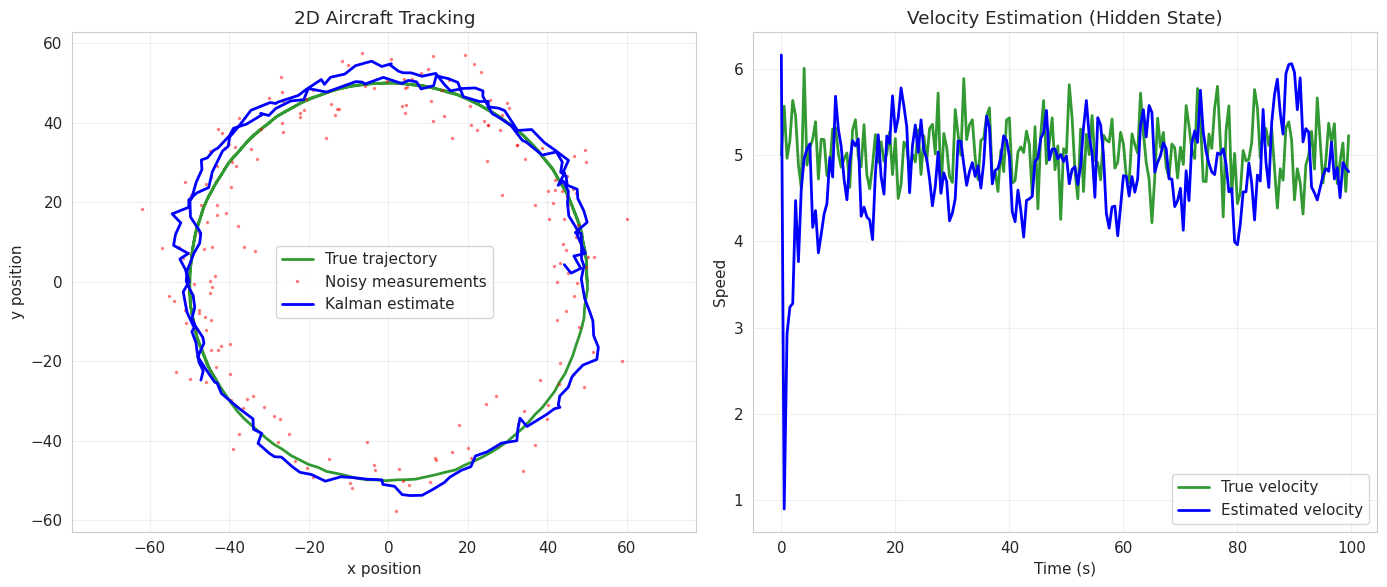

Mean position error: 3.016
Mean velocity error: 0.526


In [7]:
# 2D constant velocity model
# State: [x, vx, y, vy]^T
dt_2d = 0.5
F_2d = np.array([[1, dt_2d, 0, 0],
                 [0, 1,     0, 0],
                 [0, 0,     1, dt_2d],
                 [0, 0,     0, 1]])

# Observe both x and y positions
H_2d = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])

# Process noise (small acceleration changes)
q_2d = 0.5
Q_2d = q_2d * np.array([[dt_2d**4/4, dt_2d**3/2, 0, 0],
                        [dt_2d**3/2, dt_2d**2,   0, 0],
                        [0, 0, dt_2d**4/4, dt_2d**3/2],
                        [0, 0, dt_2d**3/2, dt_2d**2]])

# Measurement noise (GPS-like)
r_2d = 5.0
R_2d = r_2d**2 * np.eye(2)

# Generate circular trajectory
T_2d = 200
z_true_2d = np.zeros((T_2d, 4))
y_obs_2d = np.zeros((T_2d, 2))

# Initial state: circular motion
radius = 50
omega = 0.1  # angular velocity

for t in range(T_2d):
    angle = omega * t * dt_2d
    # True state (circular trajectory + noise)
    z_true_2d[t, 0] = radius * np.cos(angle)  # x
    z_true_2d[t, 1] = -radius * omega * np.sin(angle)  # vx
    z_true_2d[t, 2] = radius * np.sin(angle)  # y
    z_true_2d[t, 3] = radius * omega * np.cos(angle)  # vy

    # Add some noise to make it realistic
    if t > 0:
        process_noise = np.random.multivariate_normal(np.zeros(4), Q_2d)
        z_true_2d[t] += process_noise

    # Noisy measurements
    meas_noise = np.random.multivariate_normal(np.zeros(2), R_2d)
    y_obs_2d[t] = H_2d @ z_true_2d[t] + meas_noise

# Run Kalman filter
kf_2d = KalmanFilter(F_2d, H_2d, Q_2d, R_2d)
mu_filt_2d, Sigma_filt_2d, mu_pred_2d, Sigma_pred_2d = kf_2d.filter(
    y_obs_2d,
    mu_0=np.array([radius, 0, 0, radius*omega]),
    Sigma_0=np.eye(4) * 100
)

# Plot trajectory
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(z_true_2d[:, 0], z_true_2d[:, 2], 'g-', linewidth=2, label='True trajectory', alpha=0.8)
plt.plot(y_obs_2d[:, 0], y_obs_2d[:, 1], 'r.', markersize=3, label='Noisy measurements', alpha=0.4)
plt.plot(mu_filt_2d[:, 0], mu_filt_2d[:, 2], 'b-', linewidth=2, label='Kalman estimate')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('2D Aircraft Tracking')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot velocity estimates
plt.subplot(1, 2, 2)
vel_true = np.sqrt(z_true_2d[:, 1]**2 + z_true_2d[:, 3]**2)
vel_est = np.sqrt(mu_filt_2d[:, 1]**2 + mu_filt_2d[:, 3]**2)
t_2d = np.arange(T_2d) * dt_2d
plt.plot(t_2d, vel_true, 'g-', linewidth=2, label='True velocity', alpha=0.8)
plt.plot(t_2d, vel_est, 'b-', linewidth=2, label='Estimated velocity')
plt.xlabel('Time (s)')
plt.ylabel('Speed')
plt.title('Velocity Estimation (Hidden State)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('/home/claude/2d_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute errors
pos_error = np.sqrt((z_true_2d[:, 0] - mu_filt_2d[:, 0])**2 +
                    (z_true_2d[:, 2] - mu_filt_2d[:, 2])**2)
vel_error = np.abs(vel_true - vel_est)
print(f"Mean position error: {np.mean(pos_error):.3f}")
print(f"Mean velocity error: {np.mean(vel_error):.3f}")

**Figure for slides:** `2d_tracking.png` - 2D tracking showing hidden velocity estimation

## 7. Comparing Kalman Gain Behavior

Visualize how Kalman gain changes with different noise levels.

R=0.1: Steady-state Kalman Gain = 0.8541
R=1.0: Steady-state Kalman Gain = 0.5000
R=10.0: Steady-state Kalman Gain = 0.2000


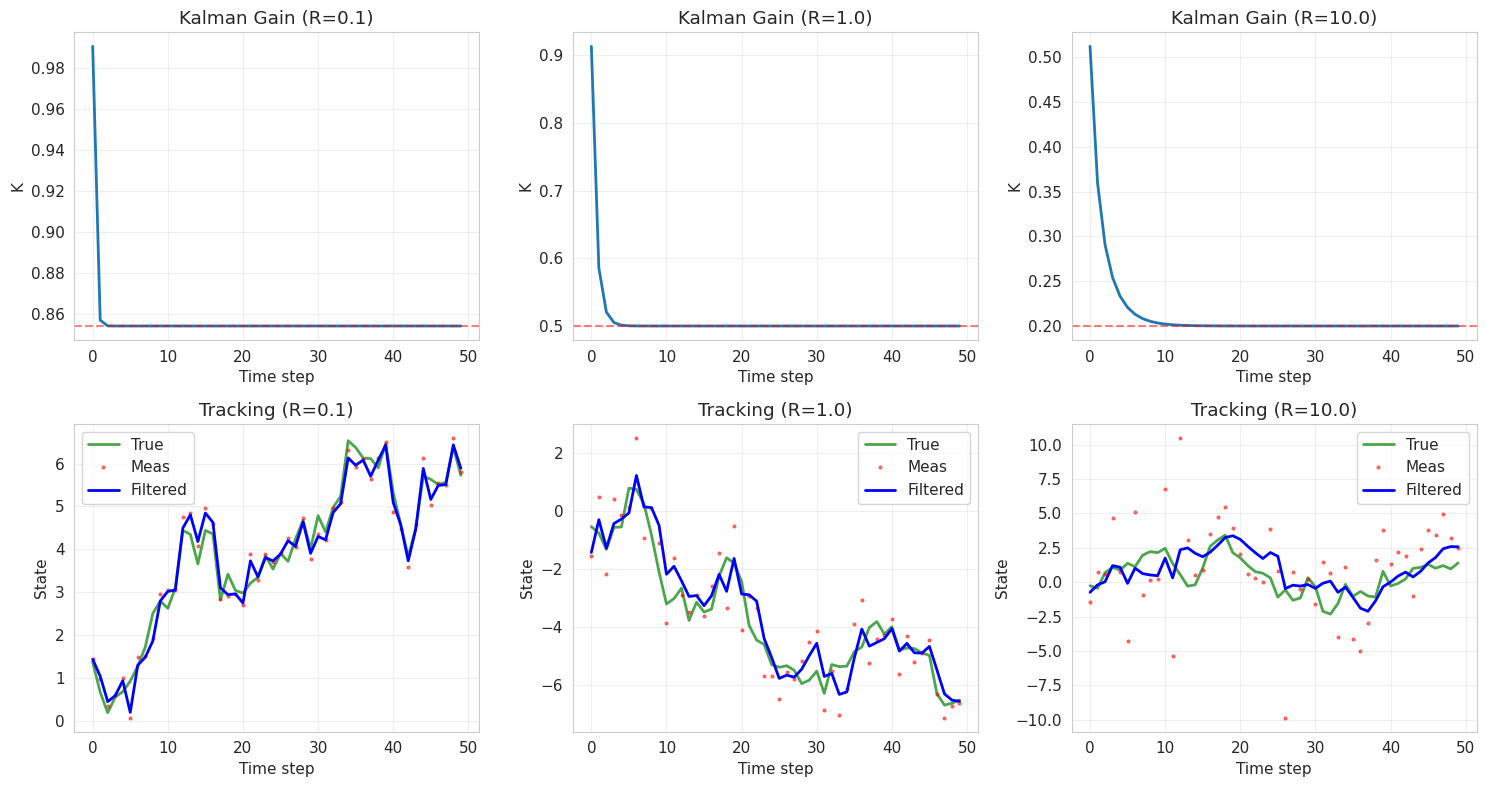

In [8]:
# Simple 1D position tracking to study Kalman gain
F_kg = np.array([[1.0]])
H_kg = np.array([[1.0]])

# Vary measurement noise
R_values = [0.1, 1.0, 10.0]
Q_fixed = 0.5

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, R_val in enumerate(R_values):
    Q_kg = np.array([[Q_fixed]])
    R_kg = np.array([[R_val]])

    # Generate data
    T_kg = 50
    z_true_kg = np.cumsum(np.random.randn(T_kg) * np.sqrt(Q_fixed))
    y_obs_kg = z_true_kg + np.random.randn(T_kg) * np.sqrt(R_val)

    # Run filter and track Kalman gain
    kf_kg = KalmanFilter(F_kg, H_kg, Q_kg, R_kg)

    mu_prev = 0.0
    Sigma_prev = 10.0
    K_history = []
    mu_history = []

    for t in range(T_kg):
        mu_pred, Sigma_pred = kf_kg.predict(np.array([mu_prev]), np.array([[Sigma_prev]]))
        mu_upd, Sigma_upd, K, _ = kf_kg.update(mu_pred, Sigma_pred, np.array([y_obs_kg[t]]))

        K_history.append(K[0, 0])
        mu_history.append(mu_upd[0])

        mu_prev = mu_upd[0]
        Sigma_prev = Sigma_upd[0, 0]

    # Plot Kalman gain convergence
    axes[0, idx].plot(K_history, linewidth=2)
    axes[0, idx].set_title(f'Kalman Gain (R={R_val})')
    axes[0, idx].set_xlabel('Time step')
    axes[0, idx].set_ylabel('K')
    axes[0, idx].grid(True, alpha=0.3)
    axes[0, idx].axhline(K_history[-1], color='r', linestyle='--', alpha=0.5)

    # Plot filtered estimate
    axes[1, idx].plot(z_true_kg, 'g-', label='True', linewidth=2, alpha=0.7)
    axes[1, idx].plot(y_obs_kg, 'r.', label='Meas', markersize=4, alpha=0.5)
    axes[1, idx].plot(mu_history, 'b-', label='Filtered', linewidth=2)
    axes[1, idx].set_title(f'Tracking (R={R_val})')
    axes[1, idx].set_xlabel('Time step')
    axes[1, idx].set_ylabel('State')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

    print(f"R={R_val}: Steady-state Kalman Gain = {K_history[-1]:.4f}")

plt.tight_layout()
#plt.savefig('/home/claude/kalman_gain_behavior.png', dpi=150, bbox_inches='tight')
plt.show()